# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, cdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Решение***

Алгоритм k-means является EM задачей. Следовательно, на E-шаге максимизируется $L(Z, \theta)$ (которая зависит от $P(X|Z, \theta)$ ), являющаяся вариационной нижней оценкой $P(X|\theta)$. На каждом шаге мы увеличиваем значение $P(X|\theta)$ и сходимся к локальному максимуму. То есть на каждом шаге мы переходим к другому варианту разбиения объектов на кластеры.  Причем вернуться к предыдущему варианту мы не можем, потому что выбор следующего варианта осуществляется таким обрахом, что значение функции на каждом шаге увеличивается. Поскольку существует не более  $k^N$ способов разбить $N$ точек данных на $k$ кластеров, количество итераций не будет превышать $k^N$. 

Задача 2.  ММП для многомерного нормального распределения.

Функция правдоподобия в общем случае записывается как:
￼
￼$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$
￼

***Решение***

Функция правдоподобия для многомерного нормального распределения:

$$ L(\mu) =  \prod_{i=1}^N p(x_i | \mu) = \prod_{i=1}^N   \frac{1}{(2\pi)^{N/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

$$ log L(\mu) = -N log((2\pi)^{N/2}|\Sigma|^{1/2}) - \frac{1}{2}  \sum_{i=1}^N  (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)$$

Чтобы найти максимум, возьмем производную по $\mu$:

$$ \frac{\partial log L(\mu)}{\partial \mu} = \frac { - \frac{1}{2}  \sum_{i=1}^N  (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)} {\partial \mu} = - \frac{1}{2}  \sum_{i=1}^N (\Sigma^{-1} + (\Sigma^{-1})^T ) (x_i - \mu) = 0$$

$$ \sum_{i=1}^N  x_i - N \mu  = 0$$

Таким образом,

$$ \mu  = \frac {\sum_{i=1}^N  x_i}{N}, $$



Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Решение***

<img src="img/fig1.png">

***Доказательство для single linkage:***


Расстояние $d_{\min} (U \cup V,S)$ равно минимальному расстоянию между элементами множества $S$ и элементами множеств $U$ и $V$. То есть равно минимальному из расстояний от $d_{\min} (U,S)$ и $d_{\min} (V,S)$:
$$ d_{\min} (U \cup V,S)=\min ({d_{\min} (U,S),d_{\min} (V,S)})$$


Попытаемся этот минимум выразить через арифметические операции. Он должен быть равен среднему значению минус половину модуля разности чисел.

<img src="img/fig2.png">


Запишем это:

$$d_{\min} (U \cup V,S)= \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $$

Что и требовалось доказать.

***Доказательство для complete linkage:***

Расстояние $d_{\max} (U \cup V,S)$ равно максимальному из расстояний от $d_{\max} (U,S)$ и $d_{\max} (V,S)$:

$$ d_{\max} (U \cup V,S)=\max ({d_{\max} (U,S),d_{\max} (V,S)})$$

Представим этот максимум через арифметические операции (к среднему значению двух чисел добавить половину модуля их разности):


$$d_{\max} (U \cup V,S)=\frac{1}{2}(d_{\max} (U,S)+d_{\max} (V,S))+\frac{1}{2}|d_{\max} (U,S)-d_{\max} (V,S)|  $$

Что и требовалось доказать.

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according
    """
    # big number to replace the distances of merged elements
    BIG_DIST = 1000000

    def __init__(self, n_clusters, metric, linkage):
        """
        n_clusters - int - number of clusters to find
        metric - string with name of metric, eg: euclidean
        linkage - string -  type of linkage
                    ('single', 'complete', 'average', 'ward')
        distance_thr - the linkage distance threshold above which,
                        clusters will not be merged.
        """
        self.n_clusters = n_clusters
        self.metric = metric
        if linkage == 'single':
            self.linkage_func = np.vectorize(self.__dist_single_linkage,
                                             excluded=['i', 'j',
                                                       'dist_square'])
        elif linkage == 'complete':
            self.linkage_func = np.vectorize(self.__dist_complete_linkage,
                                             excluded=['i', 'j',
                                                       'dist_square'])
        elif linkage == 'average':
            self.linkage_func = np.vectorize(self.__dist_average_linkage,
                                             excluded=['i', 'j',
                                                       'dist_square'])
        else:
            raise 'Unknown type of linkage'
        self.linkage = linkage
        # self.distance_thr = distance_thr
        self.linkage_matrix = ''
        self.labels = ''
        self.clusters_iter = ''

        return

    def __get_square_ind(self, d, index):
        '''
        Converts index of condensed matrix to indices
                                        in its' squareform
        d - dimension of square matrix
        index - index in condensed matrix
        '''
        b = 1 - 2 * d
        i = math.floor((-b - math.sqrt(b**2 - 8 * index))/2)
        j = int(index + i * (b + i + 2)/2 + 1)
        return (i, j)

    def __get_cond_ind(self, d, i, j):
        '''
        Converts indices in squareform matrix to index
                                in the condensed matrix
        d - dimension of square matrix
        i - row index in square matrix
        j - column index in square matrix
        '''
        index = int(d * (d - 1)/2 - (d - i)*(d - i - 1) / 2 + j - i - 1)
        return index

    def __dist_single_linkage(self, k, i, j, dist_square):

        d = 0.5 * (dist_square[i, k] +
                   dist_square[j, k] -
                   abs(dist_square[i, k] -
                   dist_square[j, k]))
        return d

    # complete linkage
    def __dist_complete_linkage(self, k, i, j, dist_square):

        d = 0.5 * (dist_square[i, k] +
                   dist_square[j, k] +
                   abs(dist_square[i, k] -
                   dist_square[j, k]))
        return d

    def __dist_average_linkage(self, k, i, j, dist_square):

        num_i = self.__find_num_obj(i, self.linkage_matrix)
        num_j = self.__find_num_obj(j, self.linkage_matrix)

        d = dist_square[i, k] * num_i / (num_i + num_j) + 
            dist_square[j, k] * num_j / (num_i + num_j)
        return d

    def __flatten(self, lis):
        """Given a list, possibly nested to any level,
                return it flattened."""
        if type(lis) == int:
            return lis
        new_lis = []
        for item in lis:
            if type(item) == type([]):
                new_lis.extend(self.__flatten(item))
            else:
                new_lis.append(item)
        return new_lis

    def __find_num_obj(self, ind_cluster):
        '''
        Finds the number of objects in cluster
        ind_cluster - int - the index of cluster
        '''
        # initial number of objects
        n = self.linkage_matrix.shape[0] + 1
        if ind_cluster < n:
            return 1
        else:
            # number of iteration when
            # the cluster was created
            i = ind_cluster - n
            # number of objects in parents
            return self.linkage_matrix[i][3]

    def __find_cluster_obj(self, ind_cluster):
        # initial number of objects
        n = self.linkage_matrix.shape[0] + 1

        if ind_cluster < n:
            return int(ind_cluster)
        else:
            # number of iteration when
            # the cluster was created
            i = int(ind_cluster - n)

            left = self.__find_cluster_obj(self.linkage_matrix[i][0])
            right = self.__find_cluster_obj(self.linkage_matrix[i][1])
            return([left, right])

    def find_cluster_obj(self, ind_cluster):
        '''
        Returns the list with objects in cluster
        with index ind_cluster
        '''
        nested_list_obj = self.__find_cluster_obj(ind_cluster)

        return self.__flatten(nested_list_obj)

    def fit_predict(self, x):
        """
        Uses data matrix x to compute model parameters and predict clusters
        """
        # number of objects
        self.x_len = x.shape[0]

        # distance matrix in square form
        dist_m_square = squareform(pdist(x, metric=self.metric))

        # list with indices of clusters at each iteration
        self.clusters_iter = list()
        self.clusters_iter.append(list(range(self.x_len)))

        # linkage matrix
        # (analogous to ouput of scipy.cluster.hierarchy.linkage)
        self.linkage_matrix = np.zeros(shape=(x.shape[0]-1, 4))

        # merging clusters
        for i in range(self.x_len-1):

            # index of element with minimal distance in condensed m
            min_ind = np.argmin(squareform(dist_m_square))
            # indices of elements with minimal distances in squarematrix
            ind_i, ind_j = self.__get_square_ind(dist_m_square.shape[0],
                                                 min_ind)

            # save indices of clusters at this step
            cur_cl_iter = self.clusters_iter[len(self.clusters_iter)-1][:]
            cur_cl_iter.remove(ind_i)
            cur_cl_iter.remove(ind_j)
            cur_cl_iter.append(self.x_len+i)
            self.clusters_iter.append(cur_cl_iter)

            # number of objects in current cluster
            n_obj_cl = self.__find_num_obj(ind_i) + 
                       self.__find_num_obj(ind_j)

            self.linkage_matrix[i] = np.array([ind_i,
                                               ind_j,
                                               dist_m_square[ind_i, ind_j],
                                               n_obj_cl])

            # calculate distances between new cluster and other objects
            new_dist = self.linkage_func(k=np.arange(0, dist_m_square.shape[0]),
                                         i=ind_i,
                                         j=ind_j,
                                         dist_square=dist_m_square)

            # set the inf value in distances that have been visited
            dist_m_square[ind_i, :] = self.__class__.BIG_DIST
            dist_m_square[:, ind_i] = self.__class__.BIG_DIST
            dist_m_square[ind_i, ind_i] = 0
            dist_m_square[ind_j, :] = self.__class__.BIG_DIST
            dist_m_square[:, ind_j] = self.__class__.BIG_DIST
            dist_m_square[ind_j, ind_j] = 0
            new_dist[ind_i] = self.__class__.BIG_DIST
            new_dist[ind_j] = self.__class__.BIG_DIST

            # add row and column with new distances
            dist_m_square = np.vstack((dist_m_square, new_dist))
            dist_m_square = np.hstack((dist_m_square,
                                       np.append(new_dist, 0).reshape(-1, 1)))

        # predict labels
        self.labels = np.zeros(self.x_len)
        clusters = self.clusters_iter[len(self.clusters_iter) - self.n_clusters]

        for i in range(1, len(clusters)):
            cl_obj = self.find_cluster_obj(clusters[i])
            self.labels[cl_obj] = i

        return self.labels

    def plot_dendrogram(self):
        """
        Visualizes clustering dendrogram
        """
        if self.linkage_matrix.any():
            d = dendrogram(self.linkage_matrix)
            return
        else:
            print("The model hasn't fit yet")


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

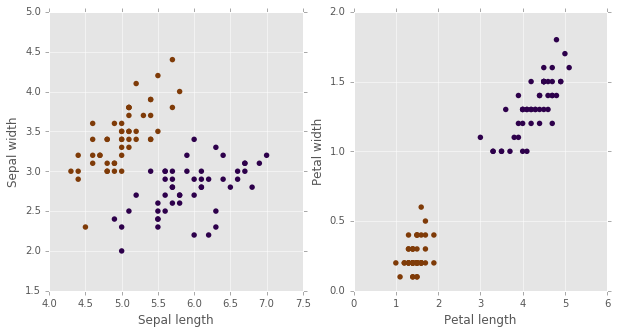

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [4]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.03497791290283203


In [45]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(n_clusters=2, metric='euclidean', linkage='complete')
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.14873909950256348


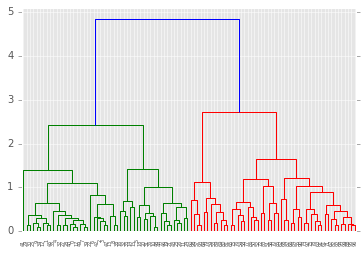

In [46]:
сustum_aggl.plot_dendrogram()

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [47]:
import nltk
from nltk.corpus import stopwords
import pymorphy2
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re

Сразу приведем слова в заголовках к нормальным формам, уберем стоп-слова из английского и русского языка.

In [48]:
# load stop words from ntlk
nltk.download('stopwords')
stopwords_rus = stopwords.words('russian')
stopwords_en = stopwords.words('english')
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Julie_2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# doc_to_title[num_title]= list with words
doc_to_title = {}

all_titles_norm = []

# create a dictionary with titles
with open('files/docs_titles.tsv', encoding='utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title

# replace title string with list of words
counter = 0
for i in range(len(doc_to_title)):
    # split, delete short and stop words, lower
    doc_to_title[i + 1] = [x.lower() for x in filter(lambda x: len(x) > 3 and x.lower()
                                          not in stopwords_en and x.lower() not in stopwords_rus,
                                          re.sub("[\W\d_]", " ", doc_to_title[i + 1]).split(" "))]

    normalized = []
    for j in doc_to_title[i + 1]:
        p = morph.parse(j)[0]
        normalized.append(p.normal_form)
    norm_string = " ".join(normalized)
    doc_to_title[i + 1] = norm_string
    all_titles_norm.append(doc_to_title[i + 1])
    counter += 1
    if counter % 1000 == 0:
        print(counter)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


Составим TF-IDF матрицу для наших заголовков:

In [50]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_titles_norm)
print(X.shape)

(28026, 23852)


Загрузим данные обучающей выборки.

In [51]:
train_data = pd.read_csv('files/train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, target))

In [52]:
len(traingroups_titledata)

129

Теперь сделаем следующее: для каждого документа из группы посчитаем **косинусные** расстояния с другими документами из группы и возьмем 13 максимальных расстояний - это и будут наши признаки.

In [53]:
y_train = []
X_train = []
groups_train = []
counter = 0
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        
        all_dist = []
        counter += 1
        if counter % 1000 == 0:
            print(counter)

        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, target_j = docs[j]
            all_dist.append(X[doc_id_j - 1].dot(X[doc_id - 1].T)[0,0])

        X_train.append(sorted(all_dist, reverse=True)[0:15])

X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)
print(X_train)
print(sum(y_train))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
(11690, 15) (11690,) (11690,)
[[ 1.          0.89330807  0.88778098 ...,  0.46269105  0.45166146
   0.43713708]
 [ 0.64347953  0.62271433  0.57365347 ...,  0.12440516  0.12175559
   0.11148379]
 [ 0.50489605  0.48494277  0.4228105  ...,  0.30157277  0.284095
   0.27073527]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.92496602  0.          0.         ...,  0.          0.          0.        ]
 [ 0.15450628  0.          0.         ...,  0.          0.          0.        ]]
3361


In [54]:
from sklearn.manifold import MDS

Теперь кластеризуем документы в наших группах.

1
 AGGL score 0.07976. f1-score 0.3137. AGGL time 0.3404
2
 AGGL score 0.3703. f1-score 0.04878. AGGL time 0.1546
3
 AGGL score 0.7771. f1-score 0.0404. AGGL time 0.1719
4
 AGGL score 0.2052. f1-score 0.07595. AGGL time 0.1562
5
 AGGL score 0.2113. f1-score 0.4186. AGGL time 0.2812
6
 AGGL score 0.2044. f1-score 0.8302. AGGL time 0.1094
7
 AGGL score 0.1392. f1-score 0.3243. AGGL time 0.1875
8
 AGGL score -0.03303. f1-score 0.5169. AGGL time 0.1719
9
 AGGL score 0.01257. f1-score 0.7273. AGGL time 0.03329
10
 AGGL score 0.5152. f1-score 0.102. AGGL time 0.1875
11
 AGGL score 0.1743. f1-score 0.3529. AGGL time 0.1689
12
 AGGL score 0.729. f1-score 0.0. AGGL time 0.1688
13
 AGGL score -0.004049. f1-score 0.6667. AGGL time 0.01563
14
 AGGL score 0.391. f1-score 0.2157. AGGL time 0.1719
15
 AGGL score 0.02863. f1-score 0.14. AGGL time 0.1875
16
 AGGL score 0.3231. f1-score 0.3148. AGGL time 0.436
17
 AGGL score 0.2727. f1-score 0.8571. AGGL time 0.2031
18
 AGGL score 0.1296. f1-score 0.5. 

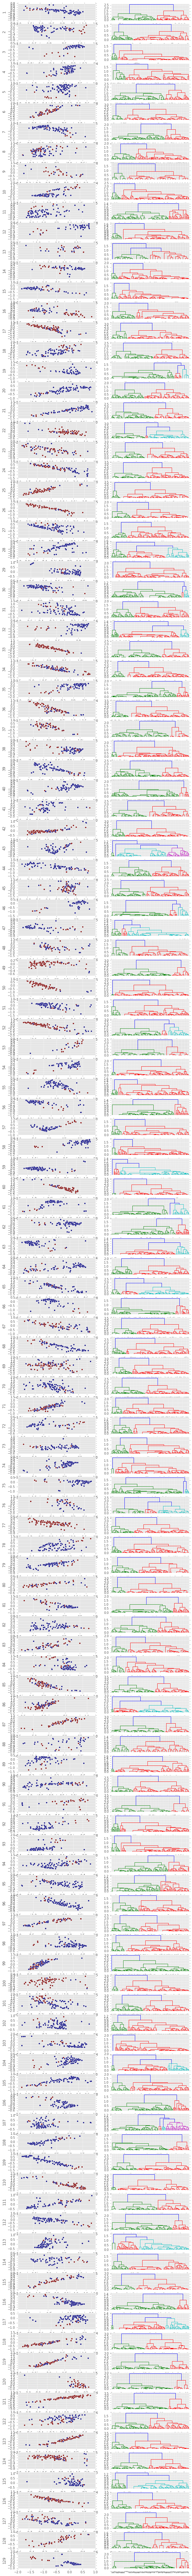

In [66]:
fig = plt.figure(figsize=(10,150))
nrows = len(np.unique(groups_train))
ncols = 2
index = 1
# список правильных меток (в нужном порядке)
y_train_all = []
# общий список предсказаний
y_pred_cl = []

for group in np.unique(groups_train):
    print(group)
    X_train_gr = X_train[groups_train==group]
    y_train_gr = y_train[groups_train==group]
    y_train_all.append(y_train_gr.tolist())
    embedding = MDS(n_components=2)
    X_gr_transformed = embedding.fit_transform(X_train_gr)
    plt.subplot(nrows, ncols, index).set_ylabel(group)
    index += 1
    plt.scatter(X_gr_transformed[:,0], X_gr_transformed[:,1], c=y_train_gr)
    aggl = Clustering(n_clusters=2, metric='euclidean', linkage='complete')
    aggl_t0 = time.time()
    aggl_pred = aggl.fit_predict(X_train_gr)
    aggl_diff = time.time() - aggl_t0
    aggl_score = smt.adjusted_rand_score(y_train_gr, aggl_pred)
    f1_score = smt.f1_score(y_train_gr, aggl_pred)
    if f1_score < 0.1:
        y_pred_cl.append((aggl_pred==0).astype(int).tolist())
    else:
        y_pred_cl.append(aggl_pred.tolist())
    #plt.text(1,1,round(f1_score,4))
    plt.subplot(nrows, ncols, index)
    index += 1
    print (" AGGL score {:.4}. f1-score {:.4}. AGGL time {:.4}".format(aggl_score,
                                                              f1_score,
                                                              aggl_diff
                                                             )
          )
    aggl.plot_dendrogram()

В некоторых случаях f1-score получался равным нулю. Это связано с тем, что в предсказании были перепутаны индексы кластеров. Если значения индексов инвертировать, то f1-score будет близок к единице. Например, это справедливо для группы 3:

 AGGL score 0.7771. f1-score 0.9832. AGGL time 0.4377


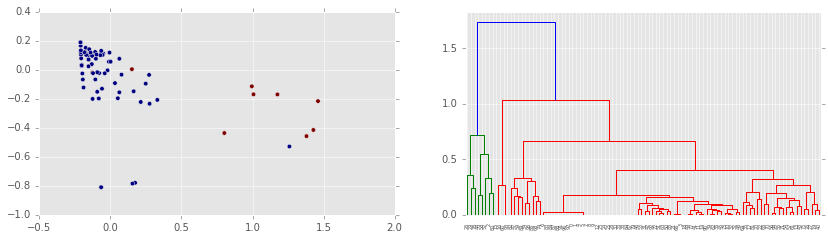

In [87]:
fig = plt.figure(figsize=(14,8))

X_train_gr = X_train[groups_train==3]
y_train_gr = y_train[groups_train==3]
embedding = MDS(n_components=2)
X_gr_transformed = embedding.fit_transform(X_train_gr)
plt.subplot(221)
plt.scatter(X_gr_transformed[:,0], X_gr_transformed[:,1], c=y_train_gr)
aggl = Clustering(n_clusters=2, metric='euclidean', linkage='complete')
aggl_t0 = time.time()
aggl_pred = aggl.fit_predict(X_train_gr)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_train_gr, aggl_pred)
f1_score = smt.f1_score((y_train_gr==0).astype(int), aggl_pred)
print (" AGGL score {:.4}. f1-score {:.4}. AGGL time {:.4}".format(aggl_score,
                                                              f1_score,
                                                              aggl_diff
                                                             )
          )
plt.subplot(222)
aggl.plot_dendrogram()

In [104]:
y_train_all = [x for subl in y_train_all for x in subl]
y_pred_cl = [x for subl in y_pred_cl for x in subl]
# f1-score для предсказаний по всем группам
smt.f1_score(y_pred_cl, y_train_all)

0.52230787199252504

В некоторых группах аномальные объекты образовывали отдельный кластер. Например, группы под номерами: 3, 12, 17, 47, 50 и другие, причем f1-score мог достигать 0.98 в пределах одной группы, правда для общего предсказания для всех групп.

Я думаю, что можно попробовать использовать отношение объекта из тестовой выборки к классу аномалий как дополнительный признак, причем так как для одних групп кластеризация работает хорошо, а для других плохо, сделать величину этого признака пропорциональной f1-score кластеризации данной группы на обучении, например.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

Хотелось бы фидбека по выполненным заданиям:  что можно было бы улучшить, за что снизили баллы и т п. И было бы вообще супер, если бы в конце курса хотя бы кратко рассказали, какие у людей были ошибки, как их исправить, как не надо делать.